# MAIA, NLP 101, Modelo Manuel

## Import Libraries

In [1]:
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

from scipy import sparse

from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score

## Data Import

In [2]:
df_raw = pd.read_csv("../data/train.csv")
df_raw.head()

,text,decade
0,\nHonorarias ¡jubiladas. 57 \ndit.ad Pontem de...,164
1,"gone. Sus amigos , sus clientes, todo \ncuanto...",182
2,"Prefosen quemanera,e per qualesfolpechas deuan...",157
3,Caistro el M a y o r a i .] Del ape...,163
4,\nlos que panden macho ; y \notros en l...,166


In [3]:
# Creamos una copia del dataframe
df = df_raw.copy()

## Exploratory Analysis

In [4]:
# Ver algunos ejemplos de texto
df['text'][3]

'Caistro  el  M  a  y  o  r  a  i  .]  Del  apellido  de  Cañroíe \nvalió  Don  Luis  enefta.  Metáfora, para  el  nombre  que  fupo \nne  de  Caiftro.  Mayoral  fe  llama  entre  los  ganaderos  el \nque  tiene  el  primer  lugar,  y  a  quien  efián  fujetos  los  de¬ \nmas, y  defia  mayoría  tomó  el  nombte. '

In [5]:
# Tamaño del dataset
df.shape

(31403, 2)

In [6]:
# Datos vacíos
df.isna().sum()

text      0
decade    0
dtype: int64

In [7]:
# Datos repetidos
df.duplicated(subset=['text']).sum()

np.int64(51)

In [8]:
df.drop_duplicates(subset=['text'], inplace=True)

print(df.shape)

(31352, 2)


There are 39 unique decades


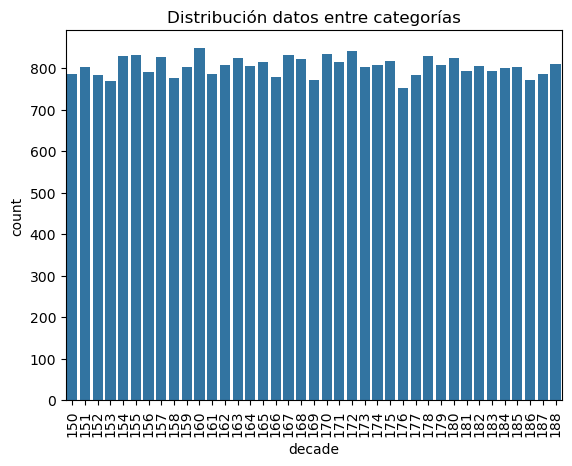

In [9]:
# Distribución de datos en décadas
print("There are " + str(len(df['decade'].unique())) + " unique decades")

# Visual de la distribución
sns.barplot(df.decade.value_counts())
plt.title("Distribución datos entre categorías")
plt.xticks(rotation=90)
plt.show()

## Data Preprocessing

In [10]:
def basic_clean(text: str) -> str:
    # Keep accents (useful in Spanish), normalize spacing & control chars only.
    text = re.sub(r'\s+', ' ', str(text)).strip()
    return text

In [11]:
test_df = df.copy().iloc[0, 0]

In [12]:
basic_clean(test_df)

'Honorarias ¡jubiladas. 57 dit.ad Pontem de poreft.Proreg.118,3, $.9.M.-70 pag.4.1. 3 Ste ph.Gratian. difcept.291, áqu len nes parece que aísilte, O ayuda Calsiodoro lib,6.epuft.s 2.Donde * llama Ocloso CINGV- y 19'

## Model Training

In [13]:
X = df["text"].astype(str).apply(basic_clean).values
y = df["decade"].astype(int).values

def to_century_label(dec):
    # 150..159 -> 150, 160..169 -> 160, etc.
    return int(dec // 10 * 10)

centuries = np.array([to_century_label(d) for d in y])

X_train, X_valid, y_train, y_valid, c_train, c_valid = train_test_split(
    X, y, centuries, test_size=0.15, random_state=42, stratify=y
)

In [14]:
t0 = time.time()

# === Base vectorizers (kept small for speed) ===
char_vec = TfidfVectorizer(
    analyzer="char_wb", ngram_range=(3,5),
    min_df=2, max_features=180_000, sublinear_tf=True
)
word_vec = TfidfVectorizer(
    analyzer="word", ngram_range=(1,2),
    min_df=3, max_features=120_000, sublinear_tf=True,
    stop_words="spanish"
)

century_clf = Pipeline([
    ("clean", FunctionTransformer(lambda x: [basic_clean(t) for t in x])),
    ("tfidf", char_vec),
    ("clf", LinearSVC(C=1.0))
])

# A compact per-century classifier: word + char stacked by simple concatenation of strings
# (fast & surprisingly effective in practice).
def concat_char_word_text(arr):
    # cheap “feature union”: original + original (lets each vec see raw text)
    return arr  # each pipeline has its own vectorizer anyway

decade_clf_proto = Pipeline([
    ("clean", FunctionTransformer(lambda x: [basic_clean(t) for t in x])),
    ("tfidf", TfidfVectorizer(
        analyzer="char_wb", ngram_range=(3,5),
        min_df=2, max_features=160_000, sublinear_tf=True
    )),
    ("clf", LogisticRegression(
        solver="saga", penalty="l2", C=2.0,
        multi_class="multinomial", max_iter=300, n_jobs=-1
    ))
])

class HierDecadeClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, century_pipe, decade_pipe, century_labels=(150,160,170,180)):
        self.century_pipe = century_pipe
        self.decade_pipe = decade_pipe
        self.century_labels = century_labels
        self.decade_models_ = {}
        self.century_model_ = None

    def fit(self, X, y):
        c = np.array([int(d // 10 * 10) for d in y])
        # Fit century
        self.century_model_ = clone(self.century_pipe).fit(X, c)
        # Fit one decade model per century
        self.decade_models_ = {}
        for cen in self.century_labels:
            idx = np.where(c == cen)[0]
            if len(idx) == 0:
                continue
            X_c, y_c = X[idx], y[idx]
            model = clone(self.decade_pipe).fit(X_c, y_c)
            self.decade_models_[cen] = model
        return self

    def predict(self, X):
        pred_cent = self.century_model_.predict(X)
        out = np.empty(len(X), dtype=int)
        for cen in self.century_labels:
            idx = np.where(pred_cent == cen)[0]
            if len(idx) == 0:
                continue
            model = self.decade_models_.get(cen, None)
            if model is None:
                # Fallback: nearest seen century model if something is missing
                model = next(iter(self.decade_models_.values()))
            out[idx] = model.predict(X[idx])
        return out

hier = HierDecadeClassifier(century_pipe=century_clf, decade_pipe=decade_clf_proto)
hier.fit(X_train, y_train)

train_time = time.time() - t0
print(f"Training time (ECOC multi-view): {train_time:.1f}s")

c:\Users\meeb1\anaconda3\envs\venv_learn\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\meeb1\anaconda3\envs\venv_learn\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\meeb1\anaconda3\envs\venv_learn\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\meeb1\anaconda3\envs\venv_learn\lib\site-packages\sklearn\linear_model\_logisti

Training time (ECOC multi-view): 56.3s


In [15]:
#pd.DataFrame(voter.cv_results_).sort_values('mean_test_score', ascending=False)

## Model Evaluation

In [16]:
pred = hier.predict(X_valid)
print(classification_report(y_valid, pred, digits=3))
print("F1-macro:", f1_score(y_valid, pred, average="macro"))

              precision    recall  f1-score   support

         150      0.844     0.644     0.731       118
         151      0.491     0.675     0.568       120
         152      0.667     0.390     0.492       118
         153      0.586     0.652     0.617       115
         154      0.490     0.597     0.538       124
         155      0.395     0.272     0.322       125
         156      0.276     0.227     0.249       119
         157      0.264     0.298     0.280       124
         158      0.222     0.190     0.205       116
         159      0.221     0.258     0.238       120
         160      0.135     0.173     0.152       127
         161      0.184     0.195     0.189       118
         162      0.227     0.248     0.237       121
         163      0.165     0.153     0.159       124
         164      0.202     0.198     0.200       121
         165      0.114     0.123     0.118       122
         166      0.127     0.077     0.096       117
         167      0.177    

In [17]:
df_test = pd.read_csv('../data/eval.csv')
df_test.head()

,id,text
0,0,P. Si en efta convocación trato folament...
1,1,«Muy santo Padre : Ayer escribiá don Juan Man-...
2,2,"Recibo, otorgado por Diego Gracián a favor de ..."
3,3,6. Los Samaritanos no admitían por \nEfcr...
4,4,ü«mi yofacaremisoiiejasfilasmaí \nI nosodlosr...


## Test Data

In [18]:
X_test = df_test["text"].astype(str).apply(basic_clean).values
y_test_pred = hier.predict(X_test)

df_to_submit = df_test.copy()

df_to_submit['answer'] = y_test_pred

df_to_submit.head()

,id,text,answer
0,0,P. Si en efta convocación trato folament...,173
1,1,«Muy santo Padre : Ayer escribiá don Juan Man-...,187
2,2,"Recibo, otorgado por Diego Gracián a favor de ...",150
3,3,6. Los Samaritanos no admitían por \nEfcr...,169
4,4,ü«mi yofacaremisoiiejasfilasmaí \nI nosodlosr...,153


In [19]:
df_to_submit = df_to_submit.iloc[:, [0, 2]]
df_to_submit.head()

,id,answer
0,0,173
1,1,187
2,2,150
3,3,169
4,4,153


In [20]:
df_to_submit.to_csv('./output/manuel_output.csv', index=False)

## Store Model

In [25]:
# === Save ===
import os
os.makedirs("output", exist_ok=True)

# Pick the object to save: the whole search or just the best estimator
try:
    MODEL_TO_SAVE = hier._best_estimator
except NameError:
    raise RuntimeError("I expected your trained object to be named `rs`. Rename here if different.")
except AttributeError:
    MODEL_TO_SAVE = hier  # if you didn't use search, or you want to keep the CV wrapper

import cloudpickle as cp
with open("output/manuel_trained_model.pkl", "wb") as f:
    cp.dump(MODEL_TO_SAVE, f)

print("Saved to output/manuel_trained_model.pkl")


Saved to output/manuel_trained_model.pkl


## Load Model and predict, check against old predictions

In [ ]:
# === Load later (even in a fresh notebook) ===
# import cloudpickle as cp
with open("output/manuel_trained_model.pkl", "rb") as f:
    model_test = cp.load(f)

probando_carga_y = model_test.predict(X_test)
